# Lookahead Uncertain Set Reduction
By Matthew Sullivan, John Gebbie, and John Lipor

This will be a brief, incomplete synopsis of my current research work as it's Christmas weekend. The paper can be [found here](https://web.cecs.pdx.edu/~lipor/Papers/sullivan2023adaptive.pdf).

### Introduction
This notebook reflects the work accepted and presented at IEE CAMSAP Dec 2023. Seabed parameters are critical for efficent SONAR systems. Previous research showed that we can classify non-reflective saebeds (clay, rock) from highly reflective seabeds (metal) using ambient acoustic noise in the ocean. This type of noise is generated by passing ships and crashing waves. 

In a practical setting, due to the vastness of the ocean, we can use a low-powered autonomous underwater vehicle (AUV) to sample the environment. As a result, it would be beneficial to develop an adaptive sampling algorithm to detect boundaries between non-reflective and highly reflective seabeds. 

We compare seabeds using the estimated covariances obtained through a reference location, $x_0$, and the current location, $x_t$. We use the Kullback-Leibler Divergence to assess how dissimilar the two distributions are. Our goal is to obtain a sublevel set sufficiently dissimilar to our reference location

$\mathcal{L} = \{x \in \mathcal{D} : s(x_0, x) < \tau \}$.

### Mean, Variance, and Sets
It is commmon to model environments using a Gaussian process for level set estimation (Gotovos, A and Krause, A. 'Active Learning for Level Set Estimation'.) Level set estimation is the process of exploring to identify where a specific phenomena is measured to be around a threshold, $\tau$. The Gaussian process provides a mean update at a current time, $\mu_t$, and the variance is computed from a kernelized Mahalanobis distance (Valko, M et al. 'Finite-Time Analysis of Kernelised Contextual Bandits'.),

$\mu_t(x) = k^T_{x,t} \left(K_t + \gamma I \right) s_t$, 

where $s_t$ are the similarity measurements compared non-reflectivel and highly reflect seabeds. 

$\sigma_t(x) = \gamma^{-1/2} \sqrt{ k(x_t, x_t) - k^T_{x_t, t} \left(K_t + \gamma I \right) k_{x_t,t}} $

### Previous Sampling Methods
In many settings, we can transform the problem into binary classification by assigning points in the environment $x \in \mathcal{D}$ as greater than the threshold, $H_t$, less than the threshold, $L_t$, or unclassified, $U_t$. 

$H_t = \{x \in \mathcal{D}: \mu_t(x) - \eta  \sigma_t(x) > \tau \}$

$L_t = \{x \in \mathcal{D}: \mu_t(x) + \eta  \sigma_t(x) < \tau \}$

$U_t = \{x \in \mathcal{D}: | \mu_t(x) - \tau | < \eta \sigma_t(x) \}$

The most popular sampling method is to sample the location with the most variance, $x_t = \arg \, \max \sigma_t(x)$. Others found success sampling the decision boundary between the two classes, $x_t = \arg \, \min |\mu_t(x) - \tau| + n$, where $n$ is some additive component to encourage exploration -- or avoid resampling the same location on the decision boundary. Other approaches began introducing a lookahead simulation. Truncated Variance Reduction (TruVar) is an example. It prioritizes variance reduction by synthetically sampling to find the location expected to maximally reduce variance across the whole field. 

Lookahead Uncertain Set Reduction (**LUSR**) performs a lookahead operation to maximally classify location -- or to reduce the size of the uncertain set, $x_t = \arg \, \max |U_t| - |\widehat{U}_t|$, where $|\widehat{U}_t|$ comes from a synthetic lookahead operation. 

The lookahead operation is restricted to the nearest $\rho$-many neighbors to reduce computational complexity. A lookahead operation takes one of the $\rho$ nearest neighbors and synthetically performs a mean update using a pessimistic sample, $\widehat{s}_{t+1}$.


$\widehat{s} = \begin{cases} \mu_t(x) - \eta \sigma_t(x), & \mu_t(x) > \tau \\ \mu_t(x) + \eta \sigma_t(x) & \mu_t(x) < \tau \\ \end{cases}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.linalg as LA
from sklearn.metrics.pairwise import haversine_distances
from matplotlib.patches import Rectangle
import itertools
import GPy as gpy
from sklearn.preprocessing import PolynomialFeatures as pf
from scipy.stats import truncnorm as tn
import networkx as nx

from AdaptiveSampler import AdaptiveSampler

import copy
import itertools
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [5]:
### DOESNT WORK ON HOME LAPTOP
# def sim_val(mu, sig, seed):
#     np.random.seed(seed)
#     a, b = (0 - mu) / sig, (1 - mu) / sig
#     sim = tn.rvs(a, b, loc=mu, scale=sig, size=1)
#     return sim


## QUESTIONABLE WORK AROUND
def sim_val(mu, sig):
    ## workout, joblib parallels won't randomly generate# on
    ## my old laptop at home. Works fine in the lab, but I traveled 
    ## home for the holidays, and it doesn't work on the laptop available
    sim = abs(mu - abs(np.random.normal(mu, sig) - mu))
    if sim > 1:
        sim = 1
    elif sim < 0:
        sim = 0
    return sim


# function to generate labels for field
def gen_field(X, degree):
    poly = pf(degree, interaction_only=False)
    Xk = poly.fit_transform(X)
    w = np.random.randn(Xk.shape[1])
    w = w / np.linalg.norm(w)
    y = Xk @ w > np.mean(Xk @ w)
    return y, w

def sample_field(X, y, T, K, tau, gamma, eta, beta, sim_params, ref_ind, G=None, n_neighbors=100, policy='rnd', seed=None):
    mu_same = sim_params[0]
    mu_diff = sim_params[1]
    sig = sim_params[2]
    accs = np.zeros(T)
    cards = np.zeros(T)
    costs = np.zeros(T)
    locs  = np.zeros(T, dtype=int)
    
    sampler = AdaptiveSampler(X, K, gamma, eta, tau, beta)
    
    for tt in range(T):
        if len(sampler.Ut) > 0:
            if policy == 'max_ambiguity_loc':
                ind = sampler.ambiguity(n_neighbors)
            elif policy == 'min_margin_loc':
                ind = sampler.margin(n_neighbors)
            elif policy == 'max_uncertainty_loc':
                ind = sampler.variance(n_neighbors)
            elif policy == 'LUSR':
                ind = sampler.LUSR(n_neighbors)
            else:
                ind = np.random.randint(X.shape[0])

            # get similarity measurement
            if y[ind] == y[ref_ind]:
                sim = sim_val(mu_same, sig)
            else:
                sim = sim_val(mu_diff, sig)

            sampler.update_dist(ind)
            # update sigma
            mu, sigma = sampler.update_prediction(ind, sim)
            
            accs[tt] = np.sum((sampler.mu > tau) == y) / sampler.N
            cards[tt] = len(sampler.Ut) / sampler.N
            costs[tt] = sampler.dist
            locs[tt] = ind
        else:
            accs[tt] = accs[tt-1]
            cards[tt] = cards[tt-1]
            costs[tt] = costs[tt-1]
            locs[tt] = locs[tt-1]
    return accs, cards, costs, locs

### Simulations
I do not believe I can upload the seabed data. As a result, this notebook will only cover simulated boundaries. A simulated boundarie consists of the two classes -- nonreflective and reflective sediment. A simulated measurement is taken from truncated normal distributions centered at 0 (dissimilar) and 1 (similar). The reference location dictating similarities is in the bottom left corner. 

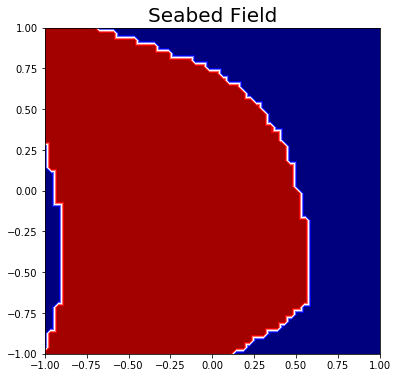

In [3]:
mu_same = 1
mu_diff = 0.0
sig = 0.45
sim_params = [mu_same, mu_diff, sig]

# generate field
# may want to include check that field has at least one
# point from each class, which is not guaranteed
res = 50
x = np.linspace(-1, 1, res)
X = np.array(list(itertools.product(x, x)))

y, w = gen_field(X, 4)

# set up thresholded field based on reference index
ref_ind = 0   # find all points similar to this index
y_thresh = np.zeros(y.shape)    # thresholded field
y_thresh[y == y[ref_ind]] = 1
y_thresh[y != y[ref_ind]] = 0

# algorithm parameters
n_neighbors = 20
gamma = 1e-2
eta = 1e-1
tau = 0.5
K = gpy.kern.RBF(input_dim=2, lengthscale=0.5).K(X)

plt.figure(figsize=(6, 6))
plt.title("Seabed Field", fontsize=20)
plt.tricontourf(X[:,0], X[:,1], y_thresh, cmap='seismic')


In [6]:
mu_same = 1
mu_diff = 0.0
sig = 0.15
sim_params = [mu_same, mu_diff, sig]

rnd_data = [] # random sampling
ambig_data = [] # max_ambiguity_loc
margin_data = [] # min_margin_loc
variance_data = [] # max_uncertainty_loc
lusr_data = []

beta = .1
n_neighbors = 10
gamma = 1e-1
eta = 5e-2
tau = 0.3
K = gpy.kern.RBF(input_dim=2, lengthscale=0.1).K(X)
T = 150

## save computation time
numBoundaries = 3
numTrials = 6
n_jobs = 6

boundaries = np.zeros((numBoundaries, res*res))

for ii in range(numBoundaries):
    print(ii)
    y, w = gen_field(X, 4) ## generate a random field
    boundaries[ii,:] = y   ## save it
    y_thresh = np.zeros(y.shape) ##  turn it into a binary
    y_thresh[y == y[ref_ind]] = 1
    y_thresh[y != y[ref_ind]] = 0
    
    policy = 'rnd'
    print(policy)
    rnd_data.append(Parallel(n_jobs=n_jobs, backend='loky', verbose=0)(delayed(sample_field)(X, y_thresh, T, K, tau, gamma, eta, beta, sim_params, ref_ind, n_neighbors=n_neighbors, policy=policy, seed=seed) for seed in range(numTrials)))

    policy = 'max_ambiguity_loc'
    print(policy)
    ambig_data.append(Parallel(n_jobs=n_jobs, backend='loky', verbose=0)(delayed(sample_field)(X, y_thresh, T, K, tau, gamma, eta, beta, sim_params, ref_ind, n_neighbors=n_neighbors, policy=policy, seed=seed) for seed in range(numTrials)))

    policy = 'min_margin_loc'
    print(policy)
    margin_data.append(Parallel(n_jobs=n_jobs, backend='loky', verbose=0)(delayed(sample_field)(X, y_thresh, T, K, tau, gamma, eta, beta, sim_params, ref_ind, n_neighbors=n_neighbors, policy=policy, seed=seed) for seed in range(numTrials)))

    policy = 'max_uncertainty_loc'
    print(policy)
    variance_data.append(Parallel(n_jobs=n_jobs, backend='loky', verbose=0)(delayed(sample_field)(X, y_thresh, T, K, tau, gamma, eta, beta, sim_params, ref_ind, n_neighbors=n_neighbors, policy=policy, seed=seed) for seed in range(numTrials)))

    policy = 'LUSR'
    print(policy)
    lusr_data.append(Parallel(n_jobs=8, backend='loky', verbose=0)(delayed(sample_field)(X, y_thresh, T, K, tau, gamma, eta, beta, sim_params, ref_ind, n_neighbors=n_neighbors, policy=policy, seed=seed) for seed in range(numTrials)))
    
rnd_data = np.array(rnd_data)
ambig_data = np.array(ambig_data)
margin_data = np.array(margin_data)
var_data = np.array(variance_data)
lusr_data = np.array(lusr_data)

rnd_accs = rnd_data[:,:,0,:]
rnd_card = rnd_data[:,:,1,:]
rnd_cost = rnd_data[:,:,2,:]
rnd_locs = rnd_data[:,:,3,:]

ambig_accs = ambig_data[:,:,0,:]
ambig_card = ambig_data[:,:,1,:]
ambig_cost = ambig_data[:,:,2,:]
ambig_locs = ambig_data[:,:,3,:]

margin_accs = margin_data[:,:,0,:]
margin_card = margin_data[:,:,1,:]
margin_cost = margin_data[:,:,2,:]
margin_locs = margin_data[:,:,3,:]

var_accs = var_data[:,:,0,:]
var_card = var_data[:,:,1,:]
var_cost = var_data[:,:,2,:]
var_locs = var_data[:,:,3,:]

lusr_accs = lusr_data[:,:,0,:]
lusr_card = lusr_data[:,:,1,:]
lusr_cost = lusr_data[:,:,2,:]
lusr_locs = lusr_data[:,:,3,:]

print("Done")

np.savez('Dec24_10neighbors_lowNoise.npz', boundaries=boundaries, 
        ambig_accs=ambig_accs, ambig_cost=ambig_cost, ambig_locs=ambig_locs,
        margin_accs=margin_accs, margin_cost=margin_cost, margin_locs=margin_locs,
        var_accs=var_accs, var_cost=var_cost, var_locs=var_locs, 
        lusr_accs=lusr_accs, lusr_cost=lusr_cost, lusr_locs=lusr_locs)

0
rnd
max_ambiguity_loc
min_margin_loc
max_uncertainty_loc
LUSR
1
rnd
max_ambiguity_loc
min_margin_loc
max_uncertainty_loc
LUSR
2
rnd
max_ambiguity_loc
min_margin_loc
max_uncertainty_loc
LUSR
Done


In [9]:
data = np.load('Dec24_10neighbors_lowNoise.npz')

rnd_accs = data['rnd_accs'].reshape(numTrials*numBoundaries, T)
rnd_card = data['rnd_card'].reshape(numTrials*numBoundaries, T)
rnd_cost = data['rnd_cost'].reshape(numTrials*numBoundaries, T)
rnd_locs = data['rnd_locs'].reshape(numTrials*numBoundaries, T)

ambig_accs = data['ambig_accs'].reshape(numTrials*numBoundaries, T)
ambig_card = data['ambig_card'].reshape(numTrials*numBoundaries, T)
ambig_cost = data['ambig_cost'].reshape(numTrials*numBoundaries, T)
ambig_locs = data['ambig_locs'].reshape(numTrials*numBoundaries, T)

margin_accs = data['margin_accs'].reshape(numTrials*numBoundaries, T)
margin_card = data['margin_card'].reshape(numTrials*numBoundaries, T)
margin_cost = data['margin_cost'].reshape(numTrials*numBoundaries, T)
margin_locs = data['margin_locs'].reshape(numTrials*numBoundaries, T)

var_accs = data['var_accs'].reshape(numTrials*numBoundaries, T)
var_card = data['var_card'].reshape(numTrials*numBoundaries, T)
var_cost = data['var_cost'].reshape(numTrials*numBoundaries, T)
var_locs = data['var_locs'].reshape(numTrials*numBoundaries, T)

lusr_accs = data['lusr_accs'].reshape(numTrials*numBoundaries, T)
lusr_card = data['lusr_card'].reshape(numTrials*numBoundaries, T)
lusr_cost = data['lusr_cost'].reshape(numTrials*numBoundaries, T)
lusr_locs = data['lusr_locs'].reshape(numTrials*numBoundaries, T)

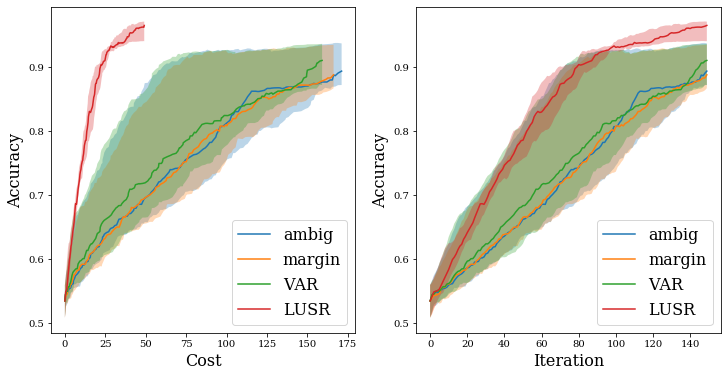

In [18]:
def plot(cost, data, label, show_cost=True):
    y = np.median(data, 0)
    if show_cost:
        c = np.median(cost, 0)
    else:
        c = np.arange(0, len(y), 1)
    y1q = np.percentile(data, 25, 0)
    y3q = np.percentile(data, 75, 0)
    plt.plot(c, y, label=label)
    plt.fill_between(c, y1q, y3q, alpha=0.3)

fs = 16
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
    
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.xlabel("Cost", fontsize=fs)
plt.ylabel("Accuracy", fontsize=fs)

label='ambig'
plot(ambig_cost, ambig_accs, label)
label='margin'
plot(margin_cost, margin_accs, label)
label='VAR'
plot(var_cost, var_accs, label)
label='LUSR'
plot(lusr_cost, lusr_accs, label)
plt.legend(fontsize=fs)

plt.subplot(1,2,2)
plt.xlabel("Iteration", fontsize=fs)
plt.ylabel("Accuracy", fontsize=fs)

label='ambig'
plot(ambig_cost, ambig_accs, label, False)
label='margin'
plot(margin_cost, margin_accs, label, False)
label='VAR'
plot(var_cost, var_accs, label, False)
label='LUSR'
plot(lusr_cost, lusr_accs, label, False)
plt.legend(fontsize=fs)


### Analysis

LUSR's biggest competitor is max variance sampling (VAR). This makes sense as they are very similar -- the location that maximally classifies points could also have the largest variance. The paper shows results for various number of neighbors and noise levels. 